# Visualization of the motivated concept

This notebook visualize the MPMC dataset.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from scipy.special import kl_div
from scipy.spatial.distance import euclidean

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsOneClassifier

from scipy.linalg import eigh

## Read data

MPMC

In [28]:
# MPMC
df = pd.read_csv("datasets/preprocessed/mpmc.csv")
df = df[df['failure.type'] != 5]

FSP

In [3]:
# faults
df = pd.read_csv("datasets/preprocessed/faults.csv")

# subset the data to check proposed method performance
df = df[(df['failure.type'] == 0) | (df['failure.type'] == 4) | (df['failure.type'] == 5) | (df['failure.type'] == 6)]

In [4]:
df['failure.type'].value_counts()

0    673
4    158
5     72
6     55
Name: failure.type, dtype: int64

In [5]:
df['target'].value_counts()

0    673
1    285
Name: target, dtype: int64

In [6]:
X = df.iloc[:, :-2]
y_bin = df['target']
y_mul = df['failure.type']

## Visualization

In [7]:
def fisher_criterion(X, y):
    """
    Compute the Fisher's Criterion for multi-class data and return the optimal projection weights.
    
    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n_samples, n_features)
    y (numpy.ndarray): Class labels of shape (n_samples,)
    
    Returns:
    float: Fisher's Criterion value
    numpy.ndarray: Projection weight matrix (n_features, n_classes - 1)
    """
    classes = np.unique(y)
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)
    
    # Initialize scatter matrices
    S_B = np.zeros((n_features, n_features))
    S_W = np.zeros((n_features, n_features))
    
    for c in classes:
        X_c = X[y == c]
        mean_c = np.mean(X_c, axis=0)
        
        # Compute between-class scatter
        n_c = X_c.shape[0]
        mean_diff = (mean_c - overall_mean).reshape(-1, 1)
        S_B += n_c * (mean_diff @ mean_diff.T)
        
        # Compute within-class scatter
        S_W += np.cov(X_c, rowvar=False) * (n_c - 1)
    
    # Compute Fisher's criterion as trace(S_B S_W^-1)
    try:
        S_W_inv = np.linalg.pinv(S_W)  # Use pseudo-inverse for stability
        J = np.trace(S_B @ S_W_inv)
        
        # Compute projection weights (generalized eigenvectors of S_W^-1 S_B)
        eigvals, eigvecs = np.linalg.eig(S_W_inv @ S_B)
        
        # Sort eigenvectors by descending eigenvalues
        sorted_indices = np.argsort(eigvals)[::-1]
        W = eigvecs[:, sorted_indices[:len(classes) - 1]]  # Select top (C-1) components
    except np.linalg.LinAlgError:
        J = 0  # If singular, assign zero
        W = np.zeros((n_features, len(classes) - 1))
    
    return J, W

### Binary

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, stratify=y_bin, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Initialize LDA with n_components ≤ (number of classes - 1)
lda = LDA(n_components = y_bin.nunique()-1)

# Fit LDA to training data and transform both train and test sets
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Print explained variance ratio
print("Explained variance ratio:", lda.explained_variance_ratio_)

Explained variance ratio: [1.]


0.6640368936854564


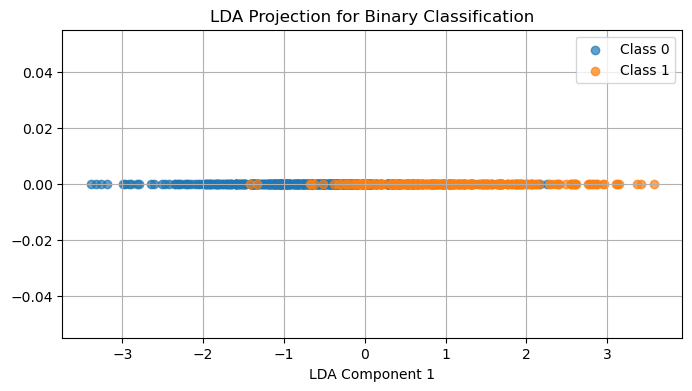

In [10]:
plt.figure(figsize=(8, 4))
plt.scatter(X_train_lda[y_train == 0], np.zeros_like(X_train_lda[y_train == 0]), 
            label='Class 0', alpha=0.7)
plt.scatter(X_train_lda[y_train == 1], np.zeros_like(X_train_lda[y_train == 1]), 
            label='Class 1', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.title('LDA Projection for Binary Classification')
plt.legend()
plt.grid()
print(fisher_criterion(X_train_scaled, y_train)[0])

In [11]:
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
# model = GaussianNB()
# model = LDA()
# model = SVC(kernel='linear', C=0.001)
# model = SVC(kernel='rbf', C=1)
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier()
# model = xgb.XGBClassifier()

model.fit(X_train_lda, y_train)

y_pred = model.predict(X_test_lda)

print(confusion_matrix(y_test, y_pred, labels=[0, 1]))
print(classification_report(y_test, y_pred))

[[165  37]
 [ 36  50]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       202
           1       0.57      0.58      0.58        86

    accuracy                           0.75       288
   macro avg       0.70      0.70      0.70       288
weighted avg       0.75      0.75      0.75       288



### Multi-class

#### Majority vs. Minority subclasses

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y_mul, stratify=y_mul, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
maj = 0
for sub in range(2, y_train.nunique()):
    X_train_local = X_train_scaled[(y_train == sub) | (y_train == maj)]
    y_train_local = y_train[(y_train == sub) | (y_train == maj)]
    X_test_local = X_test_scaled[(y_test == sub) | (y_test == maj)]
    y_test_local = y_test[(y_test == sub) | (y_test == maj)]
    
    lda = LDA(n_components=1)
    # Fit LDA to training data and transform both train and test sets
    X_train_lda = lda.fit_transform(X_train_local, y_train_local)
    X_test_lda = lda.transform(X_test_local)

    # Print explained variance ratio
    print("Explained variance ratio:", lda.explained_variance_ratio_)
    break

ValueError: n_components cannot be larger than min(n_features, n_classes - 1).

0.20685106708876544


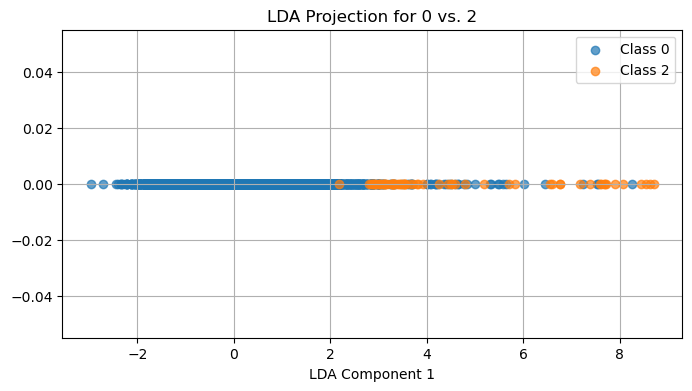

In [43]:
plt.figure(figsize=(8, 4))
plt.scatter(X_train_lda[y_train_local == maj], np.zeros_like(X_train_lda[y_train_local == maj]), 
            label='Class 0', alpha=0.7)
plt.scatter(X_train_lda[y_train_local == sub], np.zeros_like(X_train_lda[y_train_local == sub]), 
            label=f'Class {sub}', alpha=0.7)
plt.xlabel('LDA Component 1')
plt.title(f'LDA Projection for {0} vs. {sub}')
plt.legend()
plt.grid()
print(fisher_criterion(X_train_local, y_train_local)[0])

In [44]:
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
# model = GaussianNB()
# model = LDA()
# model = SVC(kernel='linear', C=0.001)
# model = SVC(kernel='rbf', C=1)
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier()
# model = xgb.XGBClassifier()

model.fit(X_train_lda, y_train_local)

y_pred_multi = model.predict(X_test_lda)
y_pred = np.where(y_pred_multi > 0, 1, 0)
y_test_bin = np.where(y_test > 0, 1, 0)

print(confusion_matrix(y_test_local, y_pred, labels=[0, 1]))
print(classification_report(y_test_local, y_pred))

[[2882   11]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2893
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00        29

    accuracy                           0.99      2922
   macro avg       0.33      0.33      0.33      2922
weighted avg       0.99      0.99      0.99      2922



/Users/alex/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alex/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alex/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alex/anaconda3/lib/python3.9/site-p

#### All at once

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_mul, stratify=y_mul, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Initialize LDA with n_components ≤ (number of classes - 1)
lda = LDA(n_components = y_train.nunique()-1)

# Fit LDA to training data and transform both train and test sets
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Print explained variance ratio
print("Explained variance ratio:", lda.explained_variance_ratio_)

Explained variance ratio: [0.71364786 0.20674519 0.07960694]


2.332994701863014


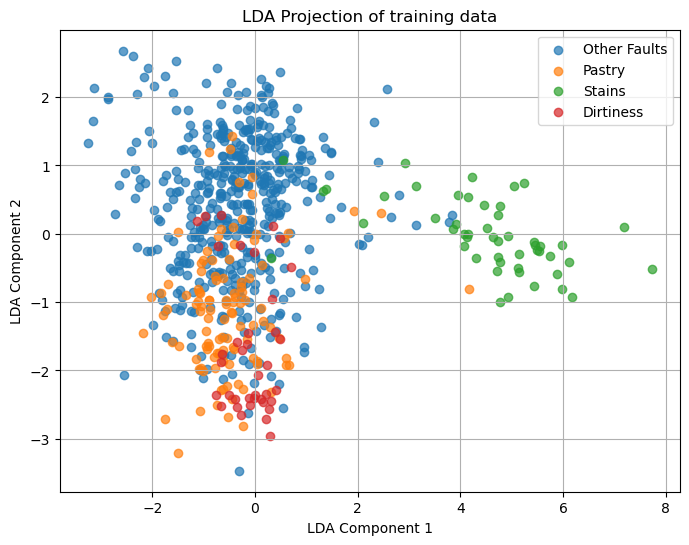

In [18]:
# Plot LDA-transformed data
plt.figure(figsize=(8,6))
for class_label in np.unique(y_train):
    plt.scatter(X_train_lda[y_train == class_label, 0], 
                X_train_lda[y_train == class_label, 1], 
                label=f'Class {class_label}', alpha=0.7)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Projection of training data')
# plt.legend(['Non Failure', 'Heat Dissipation', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'])
plt.legend(['Other Faults', 'Pastry', 'Stains', 'Dirtiness'])
plt.grid()
print(fisher_criterion(X_train_scaled, y_train)[0])

2.9500637903966687


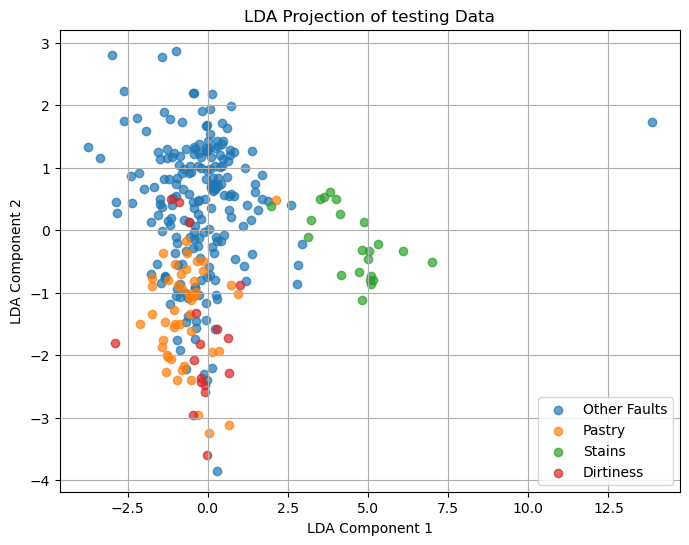

In [19]:
# Plot LDA-transformed data
plt.figure(figsize=(8,6))
for class_label in np.unique(y_test):
    plt.scatter(X_test_lda[y_test == class_label, 0], 
                X_test_lda[y_test == class_label, 1], 
                label=f'Class {class_label}', alpha=0.7)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Projection of testing Data')
# plt.legend(['Non Failure', 'Heat Dissipation', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'])
plt.legend(['Other Faults', 'Pastry', 'Stains', 'Dirtiness'])
plt.grid()
print(fisher_criterion(X_test_scaled, y_test)[0])

In [32]:
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
# model = GaussianNB()
# model = LDA()
# model = SVC(kernel='linear', C=0.001)
# model = SVC(kernel='rbf', C=1)
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier()
# model = xgb.XGBClassifier()

model.fit(X_train_lda, y_train)

y_pred_multi = model.predict(X_test_lda)
y_pred = np.where(y_pred_multi > 0, 1, 0)
y_test_bin = np.where(y_test > 0, 1, 0)

print(confusion_matrix(y_test_bin, y_pred, labels=[0, 1]))
print(classification_report(y_test_bin, y_pred))

[[187  15]
 [ 10  28]]
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       202
           1       0.65      0.74      0.69        38

    accuracy                           0.90       240
   macro avg       0.80      0.83      0.81       240
weighted avg       0.90      0.90      0.90       240



### Different LDA

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_mul, stratify=y_mul, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# lda = LDA(n_components=y_train.nunique() - 1)
# lda = LDA(n_components=y_train.nunique() - 1, solver='eigen', shrinkage='auto')
lda = KDA(n_components=y_train.nunique() - 1, kernel='rbf', alpha=1)

In [19]:
# Fit LDA to training data and transform both train and test sets
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

# Print explained variance ratio
# print("Explained variance ratio:", lda.explained_variance_ratio_)

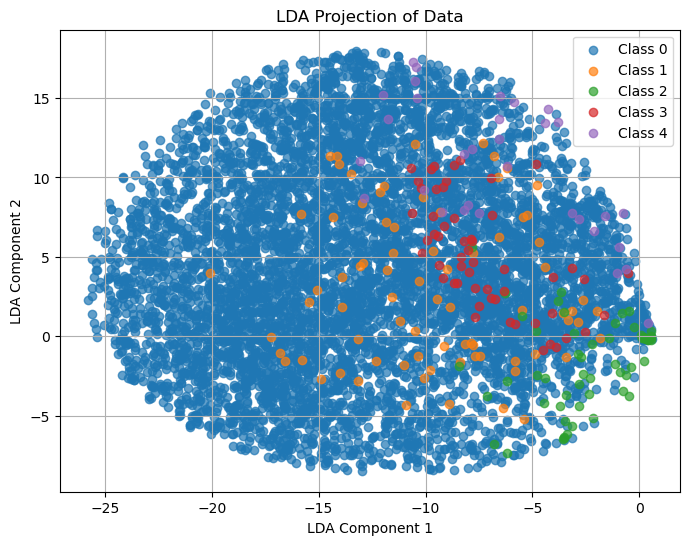

In [20]:
# Plot LDA-transformed data
plt.figure(figsize=(8,6))
for class_label in np.unique(y_train):
    plt.scatter(X_train_lda[y_train == class_label, 0], 
                X_train_lda[y_train == class_label, 1], 
                label=f'Class {class_label}', alpha=0.7)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Projection of Data')
plt.legend()
plt.grid()
# print(compute_fishers_criterion(X_train_scaled, y_train, lda.coef_[0]))

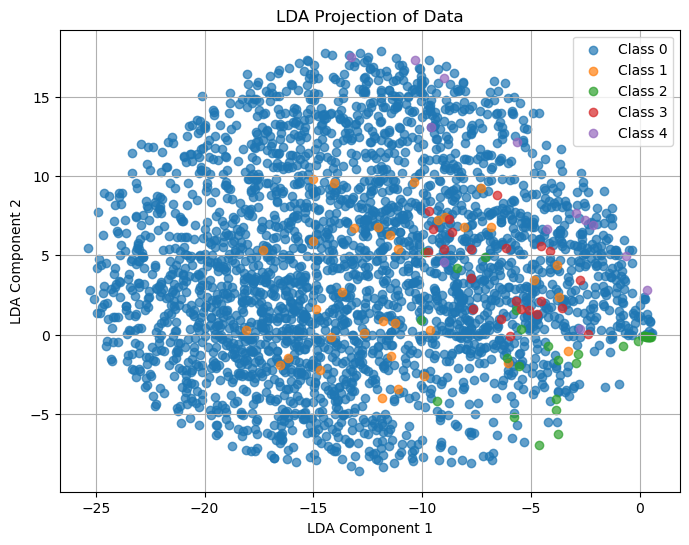

In [21]:
# Plot LDA-transformed data
plt.figure(figsize=(8,6))
for class_label in np.unique(y_test):
    plt.scatter(X_test_lda[y_test == class_label, 0], 
                X_test_lda[y_test == class_label, 1], 
                label=f'Class {class_label}', alpha=0.7)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Projection of Data')
plt.legend()
plt.grid()
# print(compute_fishers_criterion(X_train_scaled, y_train, lda.coef_[0]))

In [22]:
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
# model = GaussianNB()
# model = LDA()
# model = SVC(kernel='linear', C=0.001)
# model = SVC(kernel='rbf', C=1)
# model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier()
model = xgb.XGBClassifier()

model.fit(X_train_lda, y_train)

y_pred_multi = model.predict(X_test_lda)
y_pred = np.where(y_pred_multi > 0, 1, 0)
y_test_bin = np.where(y_test > 0, 1, 0)

print(confusion_matrix(y_test_bin, y_pred, labels=[0, 1]))
print(classification_report(y_test_bin, y_pred))

[[2872   21]
 [  69   30]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2893
           1       0.59      0.30      0.40        99

    accuracy                           0.97      2992
   macro avg       0.78      0.65      0.69      2992
weighted avg       0.96      0.97      0.97      2992



## Oversampling with LDA

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_mul, stratify=y_mul, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
# smote = SMOTE(sampling_strategy={1:100, 2: 100, 3: 100, 4: 100}, k_neighbors=1, random_state=0)
smote = SMOTE(random_state=521)
# smote = BorderlineSMOTE(kind='borderline-2', sampling_strategy={1:100, 2: 100, 3: 100, 4: 100}, k_neighbors=1)
# smote = BorderlineSMOTE(k_neighbors=3)
# smote = ADASYN(sampling_strategy={1:110, 2: 110, 3: 110, 4: 110}, n_neighbors=1)
# smote = SMOTETomek()

X_smote, y_smote = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
# Initialize LDA with n_components ≤ (number of classes - 1)
# lda = LDA(n_components=y_smote.nunique()-1)
# lda = LDA(n_components=y_smote.nunique()-1, solver='eigen', shrinkage='auto')
lda = KDA(n_components=y_train.nunique() - 1, kernel='rbf')

# Fit LDA to training data and transform both train and test sets
X_train_lda = lda.fit_transform(X_smote, y_smote)
X_test_lda = lda.transform(X_test_scaled)

In [ ]:
# Plot LDA-transformed data
plt.figure(figsize=(8,6))
for class_label in np.unique(y_smote):
    plt.scatter(X_train_lda[y_smote == class_label, 0], 
                X_train_lda[y_smote == class_label, 1], 
                label=f'Class {class_label}', alpha=0.7)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Projection of Data')
plt.legend()
plt.grid()

# print("Explained variance ratio:", lda.explained_variance_ratio_)
# print(f"Fisher's criteria: {compute_fishers_criterion(X_smote, y_smote, lda.coef_[0]):.4f}")

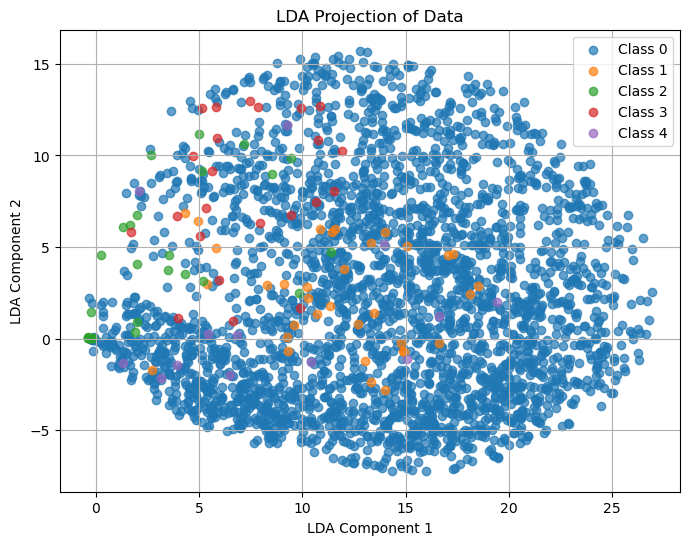

In [27]:
# Plot LDA-transformed data
plt.figure(figsize=(8,6))
for class_label in np.unique(y_test):
    plt.scatter(X_test_lda[y_test == class_label, 0], 
                X_test_lda[y_test == class_label, 1], 
                label=f'Class {class_label}', alpha=0.7)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Projection of Data')
plt.legend()
plt.grid()
# print(compute_fishers_criterion(X_train_scaled, y_train, lda.coef_[0]))

In [28]:
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
# model = GaussianNB()
# model = LDA()
# model = SVC(kernel='linear', C=0.001)
# model = SVC(kernel='rbf', C=1)
# model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier()
model = xgb.XGBClassifier()

model.fit(X_train_lda, y_smote)

y_pred_multi = model.predict(X_test_lda)
y_pred = np.where(y_pred_multi > 0, 1, 0)
y_test_bin = np.where(y_test > 0, 1, 0)

print(confusion_matrix(y_test_bin, y_pred, labels=[0, 1]))
print(classification_report(y_test_bin, y_pred))

[[2867   26]
 [  62   37]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2893
           1       0.59      0.37      0.46        99

    accuracy                           0.97      2992
   macro avg       0.78      0.68      0.72      2992
weighted avg       0.97      0.97      0.97      2992



In [29]:
# model = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
# model = GaussianNB()
# model = LDA()
# model = SVC(kernel='linear', C=0.001)
# model = SVC(kernel='rbf', C=1)
# model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = GradientBoostingClassifier()
model = xgb.XGBClassifier()

model.fit(X_train_scaled, y_train)

y_pred_multi = model.predict(X_test_scaled)
y_pred = np.where(y_pred_multi > 0, 1, 0)
y_test_bin = np.where(y_test > 0, 1, 0)

print(confusion_matrix(y_test_bin, y_pred, labels=[0, 1]))
print(classification_report(y_test_bin, y_pred))

[[2883   10]
 [  24   75]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2893
           1       0.88      0.76      0.82        99

    accuracy                           0.99      2992
   macro avg       0.94      0.88      0.90      2992
weighted avg       0.99      0.99      0.99      2992



# Appendix

### PCA: not desired since the data are imbalanced.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, stratify=y_bin, test_size=0.3, random_state=0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

In [7]:
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['Target_bin'] = y_bin
df_pca['Target_mul'] = y_mul

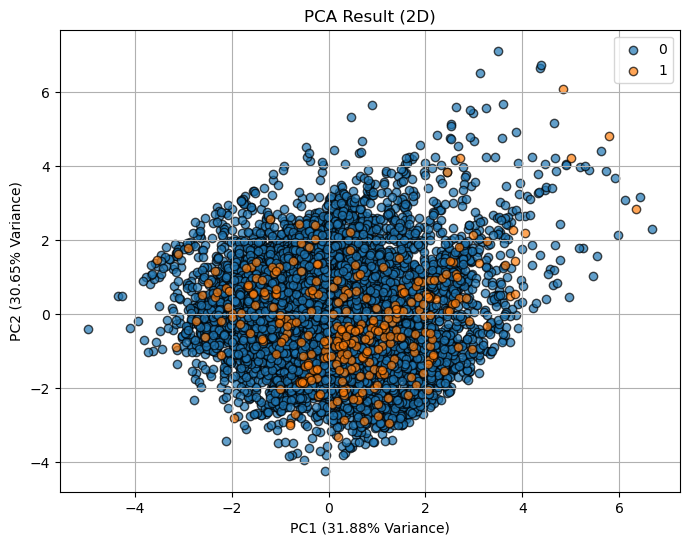

In [8]:
plt.figure(figsize=(8,6))
for target in sorted(y_bin.unique()):
    subset = df_pca[df_pca['Target_bin'] == target]
    plt.scatter(subset['PC1'], subset['PC2'], label=target, alpha=0.7, edgecolors='k')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.title('PCA Result (2D)')
plt.legend()
plt.grid(True)

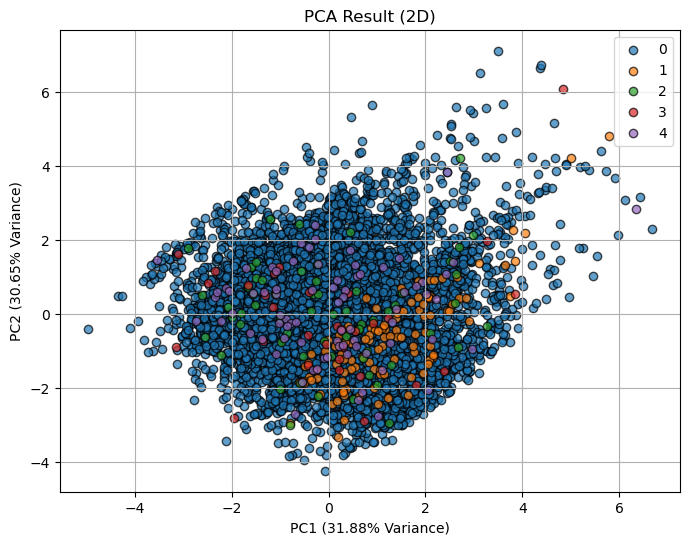

In [9]:
plt.figure(figsize=(8,6))
for target in sorted(y_mul.unique()):
    subset = df_pca[df_pca['Target_mul'] == target]
    plt.scatter(subset['PC1'], subset['PC2'], label=target, alpha=0.7, edgecolors='k')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.title('PCA Result (2D)')
plt.legend()
plt.grid(True)

In [12]:
# Apply PCA with 3 components
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

df_pca_3d = pd.DataFrame(data=X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['Target_bin'] = y_bin
df_pca_3d['Target_mul'] = y_mul

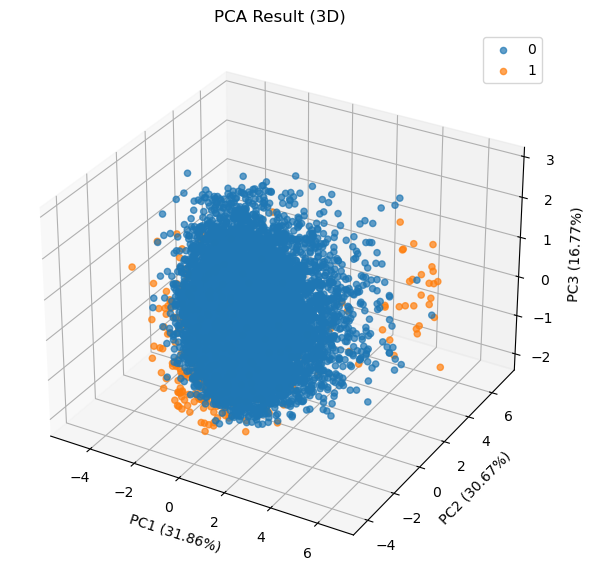

In [13]:
# Plot in 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for target in np.unique(y_bin):
    subset = df_pca_3d[df_pca_3d['Target_bin'] == target]
    ax.scatter(subset.iloc[:, 0], subset.iloc[:, 1], subset.iloc[:, 2], label=target, alpha=0.7)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)')
ax.set_title('PCA Result (3D)')
ax.legend()

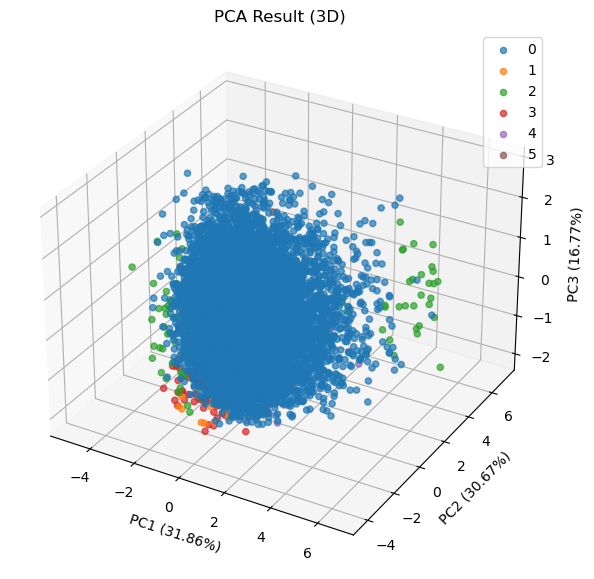

In [14]:
# Plot in 3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

for target in np.unique(y_mul):
    subset = df_pca_3d[df_pca_3d['Target_mul'] == target]
    ax.scatter(subset.iloc[:, 0], subset.iloc[:, 1], subset.iloc[:, 2], label=target, alpha=0.7)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.2f}%)')
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.2f}%)')
ax.set_title('PCA Result (3D)')
ax.legend()

## Variance

In [15]:
subs = [i for i in range(1, y_mul.nunique())]

In [16]:
df.iloc[:, :-1].corr()

,type,air.temp,proc.temp,rot.speed,torque,tool.wear,target
type,1.000000,0.015458,0.012370,0.003711,0.003372,0.006815,0.036638
air.temp,0.015458,1.000000,0.876088,0.022951,-0.014061,0.014242,0.084519
proc.temp,0.012370,0.876088,1.000000,0.019550,-0.014367,0.013885,0.039850
rot.speed,0.003711,0.022951,0.019550,1.000000,-0.874981,-0.000063,-0.045525
torque,0.003372,-0.014061,-0.014367,-0.874981,1.000000,-0.002770,0.191680
tool.wear,0.006815,0.014242,0.013885,-0.000063,-0.002770,1.000000,0.105321
target,0.036638,0.084519,0.039850,-0.045525,0.191680,0.105321,1.000000


In [17]:
# df[(df['target'] == 0) | (df['failure.type'] == 1)].iloc[:, :-1].corr()
# df[(df['target'] == 0) | (df['failure.type'] == 2)].iloc[:, :-1].corr()
# df[(df['target'] == 0) | (df['failure.type'] == 3)].iloc[:, :-1].corr()
df[(df['target'] == 0) | (df['failure.type'] == 4)].iloc[:, :-1].corr()
# df[(df['target'] == 0) | (df['failure.type'] == 5)].iloc[:, :-1].corr()

,type,air.temp,proc.temp,rot.speed,torque,tool.wear,target
type,1.000000,0.015336,0.012270,0.008614,-0.007342,-0.001701,-0.007369
air.temp,0.015336,1.000000,0.877684,0.041197,-0.034788,0.016567,0.010806
proc.temp,0.012270,0.877684,1.000000,0.029559,-0.024603,0.015042,0.007790
rot.speed,0.008614,0.041197,0.029559,1.000000,-0.888689,0.016924,0.012293
torque,-0.007342,-0.034788,-0.024603,-0.888689,1.000000,-0.025731,-0.017203
tool.wear,-0.001701,0.016567,0.015042,0.016924,-0.025731,1.000000,0.118158
target,-0.007369,0.010806,0.007790,0.012293,-0.017203,0.118158,1.000000


In [18]:
print(f"normal class variance: {df[df['failure.type'] == 0].iloc[:, :-2].var(ddof=0).sum():.0f}")

normal class variance: 32101


In [19]:
print(f"failure class variance: {df[df['failure.type'] != 0].iloc[:, :-2].var(ddof=0).sum():.0f}")

failure class variance: 149656


In [21]:
for sub in subs:
    print(f"failure type {sub} variance: {df[df['failure.type'] == sub].iloc[:, :-2].var(ddof=0).sum():.0f}")

failure type 1 variance: 5319
failure type 2 variance: 386187
failure type 3 variance: 3746
failure type 4 variance: 41656
failure type 5 variance: 16157


## Distance between distributions

### KL divergence

In [22]:
neg = df[df['target'] == 0].iloc[:, :-2]
pos = df[df['target'] == 1].iloc[:, :-2]

# Compute histograms for both distributions (normalize them to create probability distributions)
hist_neg, bins_neg = np.histogram(neg, bins=np.arange(3), density=True)
hist_pos, bins_pos = np.histogram(pos, bins=np.arange(3), density=True)

distance = kl_div(hist_pos, hist_neg)
print(f"KL between 0 and all 1s: {np.sum(distance): .4f}")

KL between 0 and all 1s:  0.0069


In [23]:
for sub in subs:
    neg = df[df['failure.type'] == 0].iloc[:, :-2]
    pos = df[df['failure.type'] == sub].iloc[:, :-2]
    
    # Compute histograms for both distributions (normalize them to create probability distributions)
    hist_neg, bins_neg = np.histogram(neg, bins=np.arange(3), density=True)
    hist_pos, bins_pos = np.histogram(pos, bins=np.arange(3), density=True)
    
    distance = kl_div(hist_pos, hist_neg)
    print(f"KL between 0 and {sub}: {np.sum(distance): .4f}")

KL between 0 and 1:  0.0094
KL between 0 and 2:  0.0052
KL between 0 and 3:  0.0762
KL between 0 and 4:  0.0023
KL between 0 and 5:  0.0406


### bhattacharyya_distance

In [24]:
def bhattacharyya_distance(P, Q):
    # Ensure the distributions are normalized (they sum to 1)
    P = P / np.sum(P)
    Q = Q / np.sum(Q)

    # Compute the Bhattacharyya coefficient
    coefficient = np.sum(np.sqrt(P * Q))

    # Compute the Bhattacharyya distance
    distance = -np.log(coefficient)
    return distance

In [25]:
neg = df[df['target'] == 0].iloc[:, :-2]
pos = df[df['target'] == 1].iloc[:, :-2]

# Compute histograms for both distributions (normalize them to create probability distributions)
hist_neg, bins_neg = np.histogram(neg, bins=np.arange(3), density=True)
hist_pos, bins_pos = np.histogram(pos, bins=np.arange(3), density=True)

distance = bhattacharyya_distance(hist_pos, hist_neg)
print(f"bhattacharyya_distance between 0 and all 1s: {np.sum(distance): .4f}")

bhattacharyya_distance between 0 and all 1s:  0.0018


In [26]:
for sub in subs:
    neg = df[df['failure.type'] == 0].iloc[:, :-2]
    pos = df[df['failure.type'] == sub].iloc[:, :-2]
    
    # Compute histograms for both distributions (normalize them to create probability distributions)
    hist_neg, bins_neg = np.histogram(neg, bins=np.arange(3), density=True)
    hist_pos, bins_pos = np.histogram(pos, bins=np.arange(3), density=True)
    
    distance = bhattacharyya_distance(hist_pos, hist_neg)
    print(f"bhattacharyya_distance between 0 and {sub}: {np.sum(distance): .4f}")

bhattacharyya_distance between 0 and 1:  0.0025
bhattacharyya_distance between 0 and 2:  0.0014
bhattacharyya_distance between 0 and 3:  0.0260
bhattacharyya_distance between 0 and 4:  0.0006
bhattacharyya_distance between 0 and 5:  0.0093


In [18]:
# df.to_csv(f"mpmc.csv", index=False)